# 5 - Full Label Set <p>
Since I had such good results on my smaller set of 7 labels, I want to run another version of the model on the full set of 20 labels. 

In [1]:
from datasets import load_dataset
ds = load_dataset('SetFit/20_newsgroups')
import pandas as pd
ds_train = pd.DataFrame(ds['train'])
ds_test = pd.DataFrame(ds['test'])

Repo card metadata block was not found. Setting CardData to empty.


### Preprocessing
Going to run the exact same preprocessing as last time. 

In [2]:
# create new column, remove newlines
ds_train['processed'] = ds_train['text'].str.replace('\n',' ')
ds_test['processed'] = ds_test['text'].str.replace('\n',' ')

In [3]:
# remove HTML tags
import re

def remove_html(text):
    clean_text = re.sub('<.*?>', '', text)
    return clean_text


ds_train['processed'] = ds_train['processed'].apply(lambda x: remove_html(x))
ds_test['processed'] = ds_test['processed'].apply(lambda x: remove_html(x))

In [4]:
# remove URLs
def remove_urls(text):
    clean_text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    return clean_text


ds_train['processed'] = ds_train['processed'].apply(lambda x: remove_urls(x))
ds_test['processed'] = ds_test['processed'].apply(lambda x: remove_urls(x))

In [5]:
# remove emails
def remove_emails(text):
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b'
    cleaned_text = re.sub(email_pattern, '', text)
    return cleaned_text


ds_train['processed'] = ds_train['processed'].apply(lambda x: remove_emails(x))
ds_test['processed'] = ds_test['processed'].apply(lambda x: remove_emails(x))

In [6]:
# remove punctuation
import string

def remove_punctuation(text):
  cleaned_text = text.translate(str.maketrans("", "", string.punctuation))
  return cleaned_text


ds_train['processed'] = ds_train['processed'].apply(lambda x: remove_punctuation(x))
ds_test['processed'] = ds_test['processed'].apply(lambda x: remove_punctuation(x))

In [7]:
# convert to lowercase
ds_train['processed'] = ds_train['processed'].str.lower()
ds_test['processed'] = ds_test['processed'].str.lower()

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mebar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mebar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [9]:
# create new column, drop stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_text = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)


ds_train['processed'] = ds_train['processed'].apply(lambda x: remove_stopwords(x))
ds_test['processed'] = ds_test['processed'].apply(lambda x: remove_stopwords(x))

In [10]:
from datasets import Dataset, DatasetDict
train = Dataset.from_pandas(ds_train[['processed','label_text','label']])
test = Dataset.from_pandas(ds_test[['processed','label_text','label']])
ds_dict = DatasetDict({
    'train': train,
    'test': test})

In [11]:
ds_dict.save_to_disk('pickles/20_labels_folder')

Saving the dataset (0/1 shards):   0%|          | 0/11314 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7532 [00:00<?, ? examples/s]

In [12]:
ds_dict

DatasetDict({
    train: Dataset({
        features: ['processed', 'label_text', 'label'],
        num_rows: 11314
    })
    test: Dataset({
        features: ['processed', 'label_text', 'label'],
        num_rows: 7532
    })
})

### Training A Model <p>
Again, I'm doing this exactly the same as the last one, aside from specifying a different directory to put the results into. 

In [12]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

In [13]:
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name,num_labels=20)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
def tokenize_process(batch):
    return tokenizer(batch['processed'], return_tensors='pt', truncation=True, padding=True)

In [15]:
tokens_train = ds_dict['train'].map(tokenize_process, batched=True)
tokens_test = ds_dict['test'].map(tokenize_process, batched=True)

Map:   0%|          | 0/11314 [00:00<?, ? examples/s]

Map:   0%|          | 0/7532 [00:00<?, ? examples/s]

In [16]:
import evaluate
import numpy as np
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [17]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)  # Get the predicted class labels
    # Compute accuracy
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    # Compute F1 score
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')
    # Return both metrics
    return {"accuracy": accuracy["accuracy"], "f1": f1["f1"]}

In [18]:
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir='model_20',
    report_to='none',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokens_train,
   eval_dataset=tokens_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics)

In [19]:
trainer.train()

  0%|          | 0/708 [00:00<?, ?it/s]

{'loss': 1.9223, 'grad_norm': 6.7198381423950195, 'learning_rate': 5.8757062146892665e-06, 'epoch': 0.71}
{'train_runtime': 3471.8327, 'train_samples_per_second': 3.259, 'train_steps_per_second': 0.204, 'train_loss': 1.757728188724841, 'epoch': 1.0}


TrainOutput(global_step=708, training_loss=1.757728188724841, metrics={'train_runtime': 3471.8327, 'train_samples_per_second': 3.259, 'train_steps_per_second': 0.204, 'total_flos': 1499217249361920.0, 'train_loss': 1.757728188724841, 'epoch': 1.0})

Loss of 1.9223, train_loss of 1.7577

In [20]:
results_train = trainer.evaluate(eval_dataset=tokens_train)
results_test = trainer.evaluate(eval_dataset=tokens_test)

  0%|          | 0/708 [00:00<?, ?it/s]

  0%|          | 0/471 [00:00<?, ?it/s]

In [21]:
print("Training Evaluation Results:", results_train)
print("Test Evaluation Results:", results_test)

Training Evaluation Results: {'eval_loss': 1.2342791557312012, 'eval_accuracy': 0.6556478698957044, 'eval_f1': 0.6296456361531486, 'eval_runtime': 165.8438, 'eval_samples_per_second': 68.221, 'eval_steps_per_second': 4.269, 'epoch': 1.0}
Test Evaluation Results: {'eval_loss': 1.37382972240448, 'eval_accuracy': 0.6032926181625067, 'eval_f1': 0.5798246822990307, 'eval_runtime': 113.4407, 'eval_samples_per_second': 66.396, 'eval_steps_per_second': 4.152, 'epoch': 1.0}


Making the graphs again:

In [18]:
import torch
import pandas as pd

texts = ds_test['processed'].tolist()

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
batch_size = 8

In [25]:
def predict_in_batches(texts, batch_size):
    predictions = []
    # Iterate over texts in smaller batches
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        
        # Tokenize the batch
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=512)
        
        # Move inputs to the same device as the model
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Make predictions
        with torch.no_grad():  # no need to compute gradients
            outputs = model(**inputs)

        # Get predicted classes
        logits = outputs.logits
        predicted_classes = torch.argmax(logits, dim=-1).cpu().numpy()
        
        predictions.extend(predicted_classes)

    return predictions

In [26]:
predicted_classes = predict_in_batches(texts, batch_size)
ds_test['predicted'] = predicted_classes

In [19]:
import matplotlib.pyplot as plt

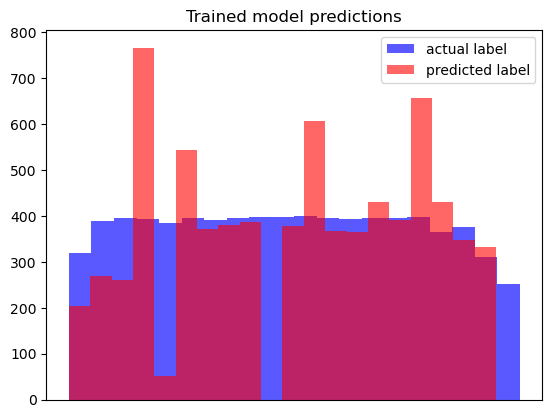

In [28]:
plt.hist(ds_test['label'],bins=20,color='blue',alpha=0.65,label='actual label')
plt.hist(ds_test['predicted'],bins=20,color='red',alpha=0.6,label='predicted label')
plt.legend()
plt.title('Trained model predictions')
plt.xticks([])

plt.savefig('charts/preds_fullset.png',bbox_inches='tight')

**Evals**:<br>
Training:<ul>
accuracy: 0.656<br>
f1: 0.630 </ul>

Test:<ul>
accuracy: 0.603<br>
f1: 0.580</ul>

Random Chance:<ul>
accuracy/f1: 0.05

In [15]:
evals = {'training':[0.656,0.630],'test':[0.603,0.580],'random chance':[0.05,0.05]}
metrics = pd.DataFrame.from_dict(evals,orient='index',columns=['accuracy','f1'])
metrics

,accuracy,f1
training,0.656,0.63
test,0.603,0.58
random chance,0.050,0.05


**Loss values**:<ul>
trainer 1: 1.922<br>
trainer 2: 1.758<br>
eval_train: 1.234<br>
eval_test: 1.374<br>
chance: 2.996

In [16]:
data = {'training1':[1.922],'training2':[1.758],'eval_train':[1.234],'eval_test':[1.374],'chance':[2.996]}
losses = pd.DataFrame.from_dict(data,orient='index',columns=['loss'])
losses

,loss
training1,1.922
training2,1.758
eval_train,1.234
eval_test,1.374
chance,2.996


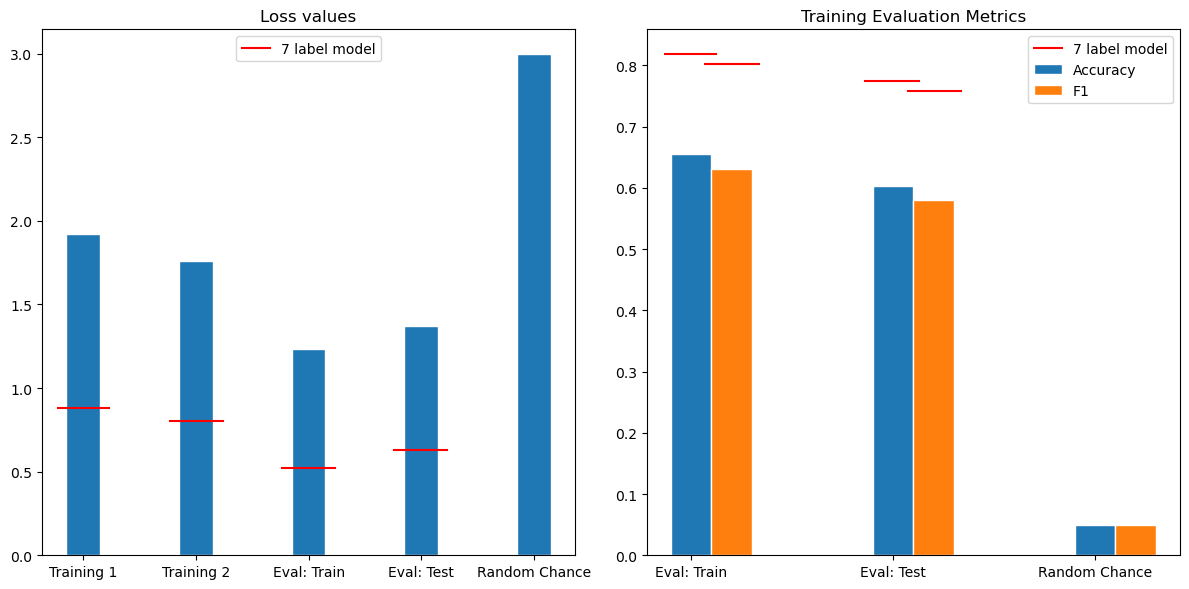

In [ ]:
# Define data for the first chart
b_width1 = 0.3
bar1 = losses['loss']
x1 = np.arange(len(bar1))

# Define data for the second chart
b_width2 = 0.2
bar1_metrics = metrics['accuracy']
bar2_metrics = metrics['f1']
x2 = np.arange(len(bar1_metrics))
x3 = x2 + b_width2

# Create 1x2 grid of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

# Plot the first chart (Loss values) on ax1
ax1.bar(x1, bar1, width=b_width1, edgecolor='white')
ax1.axhline(y=0.881,xmin=0.03,xmax=0.125,color='red',label='7 label model')
ax1.axhline(y=0.806,xmin=0.24,xmax=0.34,color='red')
ax1.axhline(y=0.521,xmin=0.45,xmax=0.55,color='red')
ax1.axhline(y=0.632,xmin=0.66,xmax=0.76,color='red')
ax1.set_xticks(x1)
ax1.set_xticklabels(['Training 1', 'Training 2', 'Eval: Train', 'Eval: Test', 'Random Chance'])
ax1.legend(loc='upper center')
ax1.set_title('Loss values')

# Plot the second chart (Accuracy and F1 metrics) on ax2
ax2.bar(x2, bar1_metrics, width=b_width2, edgecolor='white', label='Accuracy')
ax2.bar(x3, bar2_metrics, width=b_width2, edgecolor='white', label='F1')
ax2.axhline(y=0.818,xmin=0.035,xmax=0.13,color='red',label='7 label model')
ax2.axhline(y=0.802,xmin=0.11,xmax=0.21,color='red')
ax2.axhline(y=0.774,xmin=0.41,xmax=0.51,color='red')
ax2.axhline(y=0.759,xmin=0.49,xmax=0.59,color='red')
ax2.set_xticks(x2)
ax2.set_xticklabels(['Eval: Train', 'Eval: Test', 'Random Chance'])
ax2.legend()
ax2.set_yticks(np.arange(0,0.9,0.1))
ax2.set_title('Training Evaluation Metrics')

plt.tight_layout()

plt.savefig('charts/evals_fullset.png',bbox_inches='tight')

For reference, here's a comparison to the 7-label performance:<p>

|               |7 labels|20 labels|
|---------------|-------:|--------:|
|training 1 loss|   0.881|    1.922|
|training 2 loss|   0.806|    1.758|
|eval_train     |   0.521|    1.234|
|eval_test      |   0.632|    1.374|
|               |        |         |
|chance         |   1.950|    0.140|
|               |        |         |
|train accuracy |   0.818|    0.656|
|train f1       |   0.802|    0.630|
|test accuracy  |   0.774|    0.603|
|test f1        |   0.759|    0.580|

Clearly, the model had a harder time with the full set of 20 category labels. It still did much better than random chance in terms of correctness, but nowhere near as well as the 7 label version. The initial loss value was almost as high as random chance, and did decrease, but never got as low as even the highest loss from the 7 labels version. I don't know if having more rounds of training would improve that, or if I need to change other hyperparameters.